In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [2]:
data = pd.read_csv("train.csv").to_numpy()

In [3]:
np.random.shuffle(data)
size, fan_in = data.shape
fan_in -= 1
train, test = data[:int(size*0.8)], data[int(size*0.8):]
X_train, Y_train = train.T[1:], train.T[0].reshape(-1, 1)
X_test, Y_test = test.T[1:], test.T[0].reshape(-1, 1)

X_train = X_train / 255 # normalizing data  255 -> 1
X_test = X_test /  255 

In [4]:
def one_hot(a):
    classes = a.max()
    b = np.zeros((a.size, classes + 1))
    b[np.arange(a.size), a] = 1
    return b

def get_predictions(pred):
    out = np.argmax(pred, axis=1)
    return out

def softmax(Z):
    A = np.exp(Z) / sum(np.exp(Z))
    return A

In [5]:

class Linear:
    def __init__(self, fan_in, fan_out):
        self.weight = np.random.rand(fan_in, fan_out) 
        self.bias = np.random.rand(1, fan_out) 
    
    def __call__(self, X):
        self.out = np.dot(X, self.weight) + self.bias
        self.input = X
        return self.out
    
    def backward(self, chain, lr):
        self.weight -= np.dot(self.input.T, chain) * lr
        self.bias -= np.sum(chain) * lr
        grad = np.dot(chain, self.weight.T)
        return grad  
    
    def parameters(self):
        return [self.weight, self.bias]

class Tanh:
    def __call__(self, X):
        self.out = np.tanh(X)
        self.input = X
        return self.out 
    
    def backward(self, chain, lr):
        self.grad =  (1 - self.out**2) * chain
        return self.grad
    
class Sigmoid:
    def __call__(self, X):
        self.out = 1 / (1 + np.exp(-X))
        self.input = X
        return self.out 
        
    def backward(self, chain, lr):
        self.grad =  self.out * (1 - self.out) * chain
        return self.grad
         

class ReLU:
    def __call__(self, X):
        self.out = np.maximum(X, 0)
        self.input = X
        return self.out 
        
    def backward(self, chain, lr):
        self.grad =  (self.input > 0) * chain
        return self.grad

In [6]:
def MSE(pred, real):
    loss = np.sum((pred - real)**2) / (2 * real.shape[0])
    grad = (pred - real) / (real.shape[0])
    return loss, grad

In [7]:
n_hidden = 60
fan_in = 784
n = X_train.shape[1]

X = X_train.T
Y = Y_train

layers = [
    Linear(fan_in, n_hidden), ReLU(), 
    Linear(n_hidden, n_hidden), ReLU(),
    Linear(n_hidden, n_hidden), Sigmoid(),
    Linear(n_hidden, 10),
]

for layer in layers:
    if isinstance(layer, Linear):
        layer.weight -= 0.5   # reducing range (0, 1) -> (-0.5, 0.5) for lower initial confidence
        layer.bias -= 0.5
lossi = []

In [8]:
def get_performance(X, Y):  # run for test
    one_hot_Y = one_hot(Y.reshape(-1, ))

    x = X
    for layer in layers:
        x = layer(x)
    x = softmax(x)
    pred = get_predictions(x)
    correct = (pred == get_predictions(one_hot_Y))

    return np.count_nonzero(correct) / Y.shape[0]

In [9]:
epochs = 10000
batch_size = 1000
Y_one_hot = one_hot(Y_train.reshape(-1, )) # encode labels into one-hot vectors

for epoch in range(epochs):
    batch = np.random.randint(0, n - batch_size) 
    Xb = X[batch:batch_size+batch] # convert input into batches
    Yb = Y_one_hot[batch:batch_size+batch] # convert output into coresponding batches

    x = Xb
    # forward pass
    for layer in layers:
        x = layer(x)

    x = softmax(x.T).T  # convert output into a probability distribution
    loss, chain = MSE(x, Yb) # Mean Squared Error as a loss function choice

    # backward pass
    lr = 0.1 if epoch < 5000 else 0.01 # reduce learning rate in late training
    for layer in layers[::-1]:
        chain = layer.backward(chain, lr)

    if epoch%100 == 0:  # check performance every while
        pred = get_predictions(x)
        accuracy = np.count_nonzero(pred == get_predictions(Yb)) / x.shape[0]
        test_accuracy = get_performance(X_test.T, Y_test)
        print(f"Epochs: {epoch:<4} | Loss: {loss:.5f} | Accuracy: {accuracy:.5f} | Test Accuracy: {test_accuracy:.5f}")  
        lossi.append(loss)

Epochs: 0    | Loss: 0.56490 | Accuracy: 0.10400 | Test Accuracy: 0.11833
Epochs: 100  | Loss: 0.20966 | Accuracy: 0.72400 | Test Accuracy: 0.71643
Epochs: 200  | Loss: 0.13712 | Accuracy: 0.82100 | Test Accuracy: 0.79095
Epochs: 300  | Loss: 0.11200 | Accuracy: 0.85400 | Test Accuracy: 0.82869
Epochs: 400  | Loss: 0.09561 | Accuracy: 0.87800 | Test Accuracy: 0.85286
Epochs: 500  | Loss: 0.10672 | Accuracy: 0.85500 | Test Accuracy: 0.86679
Epochs: 600  | Loss: 0.07779 | Accuracy: 0.90400 | Test Accuracy: 0.87679
Epochs: 700  | Loss: 0.08583 | Accuracy: 0.89000 | Test Accuracy: 0.88440
Epochs: 800  | Loss: 0.06726 | Accuracy: 0.90800 | Test Accuracy: 0.89000
Epochs: 900  | Loss: 0.06561 | Accuracy: 0.91300 | Test Accuracy: 0.89607
Epochs: 1000 | Loss: 0.08001 | Accuracy: 0.90000 | Test Accuracy: 0.90024
Epochs: 1100 | Loss: 0.07222 | Accuracy: 0.90000 | Test Accuracy: 0.90333
Epochs: 1200 | Loss: 0.06231 | Accuracy: 0.91400 | Test Accuracy: 0.90762
Epochs: 1300 | Loss: 0.06254 | Accurac

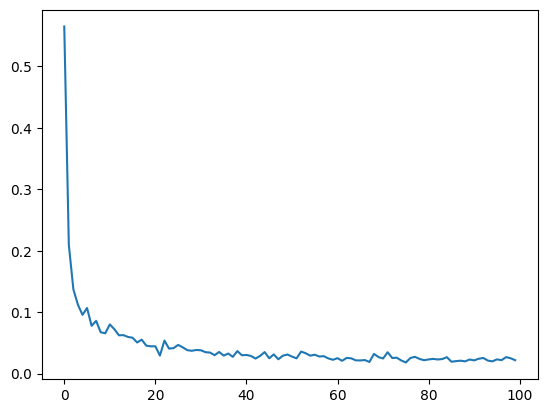

In [10]:
plt.plot(lossi)  # plot losses

In [11]:
get_performance(X_test.T, Y_test)  # final test accuracy

0.9452380952380952

layer 5 (   Sigmoid): mean +0.51, std 0.47, saturated: 41.34%


Text(0.5, 1.0, 'activation distribution')

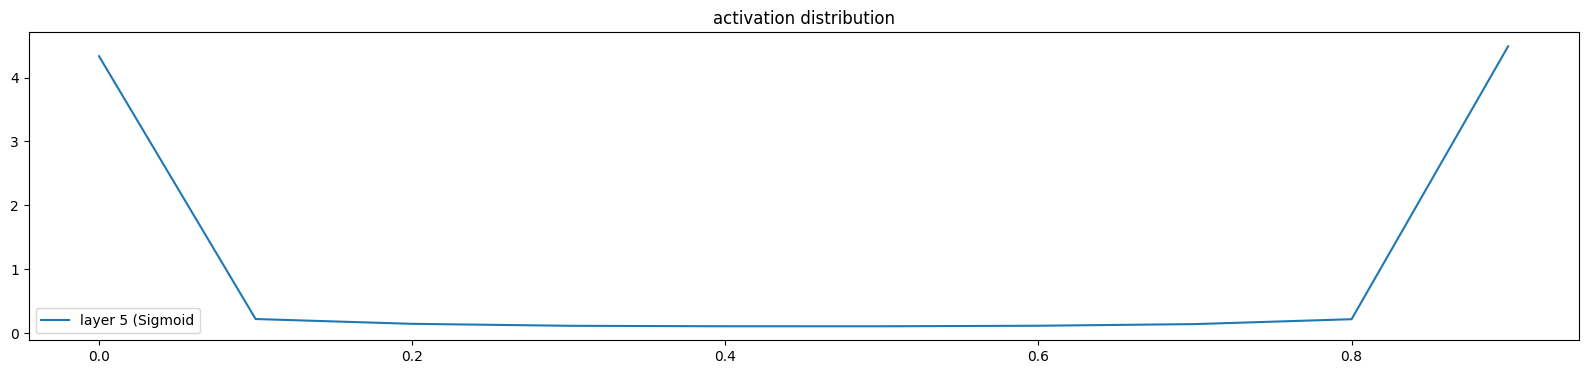

In [12]:
plt.figure(figsize=(20, 4)) # plot activations to check neuron saturation
legends = []
for i, layer in enumerate(layers[:-1]):
  if isinstance(layer, Sigmoid):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t > 0.97).mean()*100))
    hy, hx = np.histogram(t, density=True)
    plt.plot(hx[:-1], hy)
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

In [ ]:
test = pd.read_csv("test.csv").to_numpy()

for layer in layers:
    test = layer(test)
test = get_predictions(test)  # get test predictions

In [14]:
predictions = pd.DataFrame(test)
predictions = pd.DataFrame({'ImageId': range(1, len(predictions) + 1), 'Label': predictions[0]})
predictions.to_csv("submission.csv", index=False) # store test predictions into csv file